# S-Trio Entertainment Presents
## Lights, Camera, Data: Building a Profitable Movie Studio
**Authors:** Sam (TL), Sangwon (GL), Sarah (PL) 

## Project Overview
In the unpredictable realm of film production, financial outcomes can vary dramatically. Take, for instance, the contrasting fates of two notable films: "Strange World," a 2022 science-fiction adventure by Walt Disney Animation Studios, and "Paranormal Activity," a 2007 supernatural horror film.

"Strange World" incurred substantial losses for Disney, amounting to approximately \\$200 million. Despite a hefty investment exceeding \\$180 million, the film's box office revenue barely scraped past \\$75 million, leaving the studio with a significant deficit.

Conversely, "Paranormal Activity" emerged as a blockbuster success story. Despite its humble production budget of just $15,000, the film amassed an astonishing \\$195 million in box office revenue, resulting in an estimated profit of \\$78 million.

These examples underscore the high-stakes nature of film investment and the potential for both immense gains and devastating losses.

Against this backdrop, this project offers a comprehensive analysis of historical movies' financial performance, examining factors such as movie rating, genre, and budget. Additionally, it employs a simple linear regression model to forecast profit based on budgetary allocations.

The insights derived from this analysis aim to provide valuable guidance to the leadership team of **S-Trio Entertainment**'s new movie studio, empowering them to make informed and strategic investment decisions for their upcoming projects.

Source: Wikipedia

## Business Problem

With limited industry expertise and knowledge, **S-Trio Entertainment** has decided to create a new movie studio. To make informed and strategic investment decisions for their upcoming projects, the company's C-suite has tasked the team with delving into various movie databases for key insights.

Specifically, the leadership seeks answers to the following questions:

1. Which movie rating category - R-rated or non-R-rated - demonstrates superior financial performance?
2. Amongst different movie genres, which exhibits the highest profitability?
3. What is the correlation between production budget and profit?


## Data Understanding
For the project, following database and datasets were utilized for the analysis:  
- IMDB
- Rotten Tomatoes
- The Numbers

Each database or dataset encompasses mostly distinct categories of movie information. For instance, the Rotten Tomatoes dataset includes movie ratings while the The Numbers dataset provides data on domestic and worldwide gross revenue. Given the variations in data structure and content across these datasets, selected tables were utilized either independently or in conjunction with others. 

We first start by importing packages and raw data needed to evaluate the business problem.

In [2]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
from random import gauss, seed
from scipy import stats
import seaborn as sns
from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm 

%matplotlib inline 

pd.set_option('display.max_columns', None)

In [3]:
#Initiating SQL connection

conn = sqlite3.connect('data/im.db')
cursor = conn.cursor()

In [4]:
#Reading the rt.movie.info data for First Business Recommendation

movie_info_df = pd.read_csv("data/rt.movie_info.tsv.gz", sep="\t", encoding='windows-1252')
movie_info_df.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


Pulling in the data for the second and third business recommendations

In [5]:
movie_budget_df = pd.read_csv("data/tn.movie_budgets.csv.gz")

movie_budget_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [6]:
#Pulling needed data from IMDB database using SQL

df_movie_imdb = pd.read_sql("""
  SELECT *
    FROM movie_basics""", conn)

df_movie_imdb.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


## Data Preparation

Overall data cleaning steps for the analyses:
1. Handle missing values
2. Standardize number format and change data type
3. Reclassify group categories
4. Aggregate data into reclassified groups
5. Take samples from the dataset

We start with the data cleaning and filtering for our first business recommendation.

In [5]:
# need to change box_office dtype from object to int64
movie_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [6]:
#drop na values in box office and rating columns
movie_info_df.dropna(subset=['box_office', 'rating'], inplace=True)

In [7]:
#removing commas and making the value to int64
movie_info_df['box_office_clean'] = movie_info_df['box_office'].str.replace(",", "").astype(np.int64)

In [8]:
#count of each rating type
movie_info_df['rating'].value_counts()

R        142
PG-13    117
PG        52
NR        19
G          9
NC17       1
Name: rating, dtype: int64

In [9]:
#box office total per rating
movie_info_df.groupby(by = 'rating').sum()['box_office_clean']

rating
G         274031600
NC17        1260219
NR         47238725
PG       2653744950
PG-13    6612858122
R        3298910048
Name: box_office_clean, dtype: int64

In [10]:
#making rating column binary - R or non-R
movie_info_df['rating'].replace("G","Non-R", inplace=True)
movie_info_df['rating'].replace("NC17", "R", inplace=True)
movie_info_df['rating'].replace("NR", "Non-R", inplace=True)
movie_info_df['rating'].replace("PG", "Non-R", inplace=True)
movie_info_df['rating'].replace("PG-13", "Non-R", inplace=True)

In [11]:
#confirming above code worked
movie_info_df['rating'].value_counts()

Non-R    197
R        143
Name: rating, dtype: int64

In [12]:
#box office total per rating
movie_info_df.groupby(by = 'rating').sum()['box_office_clean']

rating
Non-R    9587873397
R        3300170267
Name: box_office_clean, dtype: int64

<hr style="border:0.5px solid gray">

We did a second data cleaning for our second and third business recommendations

In [14]:
#Starting with movie budget dataframe

movie_budget_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [17]:
#Removing commas and $ sign in the object values to int64

movie_budget_df['production_budget'] = movie_budget_df['production_budget'].str.replace('$','').str.replace(',','').astype(np.int64)
movie_budget_df['domestic_gross'] = movie_budget_df['domestic_gross'].str.replace('$','').str.replace(',','').astype(np.int64)
movie_budget_df['worldwide_gross'] = movie_budget_df['worldwide_gross'].str.replace('$','').str.replace(',','').astype(np.int64)


In [19]:
#We have defined 
#Creating a Financial Metrics column "Profit"

movie_budget_df['profit'] = movie_budget_df['worldwide_gross'] - movie_budget_df['production_budget']

In [29]:
#Combining Movie Budget Database with IMDB information

df_merged_mb = movie_budget_df.merge(df_movie_imdb, left_on='movie', right_on='primary_title')

df_merged_mb

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,tt1775309,Avatar,Abatâ,2011,93.0,Horror
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy"
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,tt6565702,Dark Phoenix,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi"
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi"
4,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3810,68,"Jul 6, 2001",Cure,10000,94596,94596,84596,tt5936960,Cure,Cure,2014,NaN,None
3811,70,"Apr 1, 1996",Bang,10000,527,527,-9473,tt6616538,Bang,Bang,2015,NaN,None
3812,73,"Jan 13, 2012",Newlyweds,9000,4584,4584,-4416,tt1880418,Newlyweds,Newlyweds,2011,95.0,"Comedy,Drama"
3813,78,"Dec 31, 2018",Red 11,7000,0,0,-7000,tt7837402,Red 11,Red 11,2019,77.0,"Horror,Sci-Fi,Thriller"


In [30]:
#We notice here that there are some duplicates

df_merged_mb['movie_id'].value_counts()

tt2075392    3
tt5884960    3
tt2089701    3
tt4047846    3
tt2224026    3
            ..
tt4698684    1
tt1355683    1
tt5770620    1
tt1053810    1
tt1411250    1
Name: movie_id, Length: 3606, dtype: int64

In [31]:
#We investicate the duplicates for movie id 'tt2075392'
df_merged_mb[df_merged_mb['movie_id'] == 'tt2075392']

#This looks fine but we do a second check

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
207,44,"Mar 27, 2015",Home,130000000,177397510,385997896,255997896,tt2075392,Home,Yurt,2011,76.0,Drama
231,56,"Jun 5, 2009",Home,12000000,0,0,-12000000,tt2075392,Home,Yurt,2011,76.0,Drama
255,60,"Apr 23, 2009",Home,500000,15433,44793168,44293168,tt2075392,Home,Yurt,2011,76.0,Drama


In [35]:
#As sanity check, we investicate the duplicates for movie id 'tt5884960'
df_merged_mb[df_merged_mb['movie_id'] == 'tt5884960']

#We find there is something weird going on with this data where the release dates, 
#movie types, and production budget columns have the same pattern

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
224,44,"Mar 27, 2015",Home,130000000,177397510,385997896,255997896,tt5884960,Home,Home,2015,58.0,Documentary
248,56,"Jun 5, 2009",Home,12000000,0,0,-12000000,tt5884960,Home,Home,2015,58.0,Documentary
272,60,"Apr 23, 2009",Home,500000,15433,44793168,44293168,tt5884960,Home,Home,2015,58.0,Documentary


In [36]:
#To correct for the odd data, we filter out the movie type "Home"
df_merged_mb = df_merged_mb[df_merged_mb['movie'] != 'Home']


In [37]:
#Our team decided filtering by production budget is needed to weed out homemade movies
#As such, we look at movies with production budget over $1 million.

df_merged_mb = df_merged_mb[df_merged_mb['production_budget'] >= 1000000]

In [38]:
df_merged_mb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3424 entries, 0 to 3520
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 3424 non-null   int64  
 1   release_date       3424 non-null   object 
 2   movie              3424 non-null   object 
 3   production_budget  3424 non-null   int64  
 4   domestic_gross     3424 non-null   int64  
 5   worldwide_gross    3424 non-null   int64  
 6   profit             3424 non-null   int64  
 7   movie_id           3424 non-null   object 
 8   primary_title      3424 non-null   object 
 9   original_title     3423 non-null   object 
 10  start_year         3424 non-null   int64  
 11  runtime_minutes    2986 non-null   float64
 12  genres             3365 non-null   object 
dtypes: float64(1), int64(6), object(6)
memory usage: 374.5+ KB


In [39]:
#After assessing the null values, runtime_minutes are not necessary for our analysis
#To do the final clean up of the merged dataframe, we drop the null values in the genres category.

df_merged_mb = df_merged_mb.dropna(subset = ['genres'])

<hr style="border:2px solid gray">

# Business Recommendations

##  Analysis Part 1 - Effect of Film Rating on Box Office Revenue

This section analyzes the financial performance (i.e., box office revenue) between the R and non-R rated films. 

In [43]:
#Getting box office values for R and non-R categories
R = movie_info_df[movie_info_df['rating'] == 'R']['box_office_clean'].values
non_R = movie_info_df[movie_info_df['rating'] == 'Non-R']['box_office_clean'].values

In [44]:
#Creating samples for each category

sample_R = np.random.choice(R, size=100, replace=False)
sample_non_R = np.random.choice(non_R, size=100, replace=False)

In [45]:
sample_R_mean = sample_R.mean()
sample_non_R_mean = sample_non_R.mean()

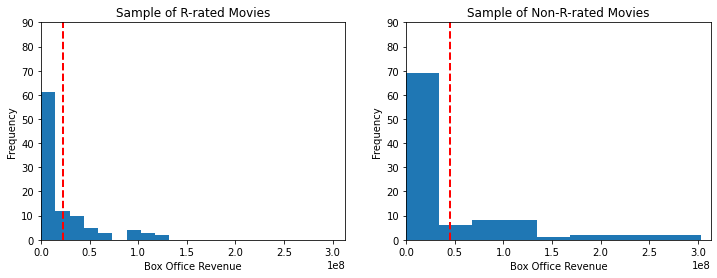

In [46]:
#Visuals - bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

bin_size = 9

ax1.set_title('Sample of R-rated Movies')
ax1.set_xlabel('Box Office Revenue')
ax1.set_ylabel('Frequency')
ax1.hist(sample_R, bins = bin_size)

ax1.axvline(x=sample_R_mean, color='red', linestyle='--', linewidth=2, label='Mean')

ax2.set_title('Sample of Non-R-rated Movies')
ax2.set_xlabel('Box Office Revenue')
ax2.set_ylabel('Frequency')
ax2.hist(sample_non_R, bins = bin_size)

ax2.axvline(x=sample_non_R_mean, color='red', linestyle='--', linewidth=2, label='Mean')

max_x = max(max(sample_R), max(sample_non_R)) + 10000000
max_y = 90

ax1.set_xlim(0, max_x)
ax1.set_ylim(0, max_y)
ax2.set_xlim(0, max_x)
ax2.set_ylim(0, max_y)

plt.show();

#### Observation
- Mean of non-R rated movies is greater than mean of R-rated movies based on the samples. In order to validate the aforementioned statement, a two-sample T-test will be performed. 

#### Hypothesis
- **Null Hypothesis:** R-rated movies bring in greater or equal box office revenue than Non-R-rated movies
- **Alternative Hypothesis:** R-rated movies bring in less box office revenue than Non-R-rated movies

In [47]:
#Two sample t-test
pvalue = stats.ttest_ind(sample_R, sample_non_R, equal_var = False).pvalue / 2
pvalue

0.002032493645833144

### Conclusion

We've set our alpha to be 0.05. As the p-value above is lower than alpha, we reject the null hypothesis and conclude that R-rated movies bring in less box office revenue than Non-R movies. Therefore, it will be beneficial for the Company to pursue non-R movies.

### Limitations to the Analysis
- Do NOT filter for movie release date. Considering all data points in the data set due to limited data
- Do NOT adjust for inflation for the box office revenue
- Do NOT account for the budget of each title

##  Analysis Part 1a - Additional Analysis on a Specific Genre
To investigate whether the conclusion drawn from the first analysis may differ for a given genre, the team has conducted additional analyses focusing on two top genres (i.e., Adventure and Action).

### Action Movies

In [48]:
# R Action movies vs Non-R Action movies
R_Action = movie_info_df[(movie_info_df['genre'].str.contains('Action')) 
                         & (movie_info_df['rating'] == 'R')]['box_office_clean'].values
Non_R_Action = movie_info_df[(movie_info_df['genre'].str.contains('Action')) 
                             & (movie_info_df['rating'] == 'Non-R')]['box_office_clean'].values

In [49]:
#Taking samples
R_Action_sample = np.random.choice(R_Action, size=20, replace=False)
Non_R_Action_sample = np.random.choice(Non_R_Action, size=20, replace=False)

In [50]:
R_Action_sample_mean = R_Action_sample.mean()
Non_R_Action_sample_mean = Non_R_Action_sample.mean()

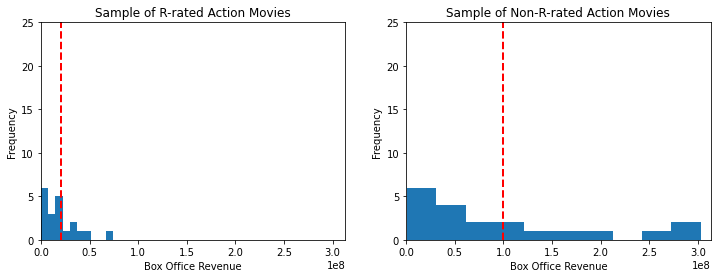

In [51]:
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

bin_size = 10

ax1.set_title('Sample of R-rated Action Movies')
ax1.set_xlabel('Box Office Revenue')
ax1.set_ylabel('Frequency')
ax1.hist(R_Action_sample, bins = bin_size)

ax1.axvline(x=R_Action_sample_mean, color='red', linestyle='--', linewidth=2, label='Mean')

ax2.set_title('Sample of Non-R-rated Action Movies')
ax2.set_xlabel('Box Office Revenue')
ax2.set_ylabel('Frequency')
ax2.hist(Non_R_Action_sample, bins = bin_size)

ax2.axvline(x=Non_R_Action_sample_mean, color='red', linestyle='--', linewidth=2, label='Mean')

max_x = max(max(R_Action_sample), max(Non_R_Action_sample)) + 10000000
max_y = 25

ax1.set_xlim(0, max_x)
ax1.set_ylim(0, max_y)
ax2.set_xlim(0, max_x)
ax2.set_ylim(0, max_y)

plt.show();

#### Observation
- Mean of non-R rated Action movies is greater than mean of R-rated Action movies based on the samples. In order to validate the aforementioned statement, a two-sample T-test will be performed. 

#### Hypothesis
- ***Null Hypothesis:*** R-rated Action movies bring in greater or equal box office revenue than Non-R-rated Action movies
- ***Alternative Hypothesis:*** R-rated Action movies bring in less box office revenue than Non-R-rated Action movies

In [52]:
#Two sample t-test
pvalue = stats.ttest_ind(R_Action_sample, Non_R_Action_sample, equal_var = False).pvalue / 2
pvalue

0.0010134582074435342

### Conclusion

We've set our alpha to be 0.05. As the p-value above is lower than alpha, we reject the null hypothesis and conclude that R-rated Action movies bring in less box office revenue than Non-R Action movies. Therefore, it will be beneficial for the Company to pursue non-R movies.

### Adventure Movies

In [53]:
# R Adventure movies vs Non-R Adventure movies
R_Adventure = movie_info_df[(movie_info_df['genre'].str.contains('Adventure')) 
                         & (movie_info_df['rating'] == 'R')]['box_office_clean'].values
Non_R_Adventure = movie_info_df[(movie_info_df['genre'].str.contains('Adventure')) 
                             & (movie_info_df['rating'] == 'Non-R')]['box_office_clean'].values

In [54]:
#Taking samples
R_Adventure_sample = np.random.choice(R_Adventure, size=20, replace=False)
Non_R_Adventure_sample = np.random.choice(Non_R_Adventure, size=20, replace=False)

In [55]:
R_Adventure_sample_mean = R_Adventure_sample.mean()
Non_R_Adventure_sample_mean = Non_R_Adventure_sample.mean()

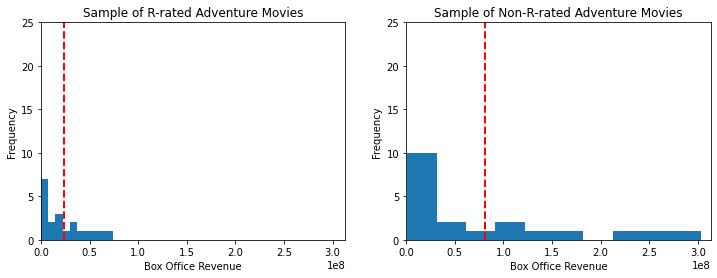

In [56]:
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

bin_size = 10

ax1.set_title('Sample of R-rated Adventure Movies')
ax1.set_xlabel('Box Office Revenue')
ax1.set_ylabel('Frequency')
ax1.hist(R_Adventure_sample, bins = bin_size)

ax1.axvline(x=R_Adventure_sample_mean, color='red', linestyle='--', linewidth=2, label='Mean')

ax2.set_title('Sample of Non-R-rated Adventure Movies')
ax2.set_xlabel('Box Office Revenue')
ax2.set_ylabel('Frequency')
ax2.hist(Non_R_Adventure_sample, bins = bin_size)

ax2.axvline(x=Non_R_Adventure_sample_mean, color='red', linestyle='--', linewidth=2, label='Mean')

max_x = max(max(R_Adventure_sample), max(Non_R_Adventure_sample)) + 10000000
max_y = 25

ax1.set_xlim(0, max_x)
ax1.set_ylim(0, max_y)
ax2.set_xlim(0, max_x)
ax2.set_ylim(0, max_y)

plt.show();

#### Observation
- Mean of non-R rated Adventure movies is greater than mean of R-rated Adventure movies based on the samples. In order to validate the aforementioned statement, a two-sample T-test will be performed. 

#### Hypothesis
- ***Null Hypothesis:*** R-rated Adventure movies bring in greater or equal box office revenue than Non-R-rated Adventure movies
- ***Alternative Hypothesis:*** R-rated Adventure movies bring in less box office revenue than Non-R-rated Adventure movies

In [57]:
#Two sample t-test
pvalue = stats.ttest_ind(R_Adventure_sample, Non_R_Adventure_sample, equal_var = False).pvalue / 2
pvalue

0.0064745112229611206

### Conclusion

We've set our alpha to be 0.05. As the p-value above is lower than alpha, we reject the null hypothesis and conclude that R-rated Adventure movies bring in less box office revenue than Non-R Adventure movies. Therefore, it will be beneficial for the Company to pursue non-R movies.

### First Recommendation

Based on the analyses, **S-Trio Entertainment** should pursue non-R rated movies as non-R rated movies have higher box office revenue than R-rated movies regardless of genre. 

<hr style="border:1px solid gray">

## Analysis Part 2 - Profit Breakdown By Genre Category

We next move on to the analysis of the profit breakdown by genre category.

In [58]:
# Grouping profit by comedy 
comedy_profit = df_merged_mb[df_merged_mb['genres'].str.contains('Comedy')]['profit']
adventure_profit = df_merged_mb[df_merged_mb['genres'].str.contains('Adventure')]['profit']
action_profit = df_merged_mb[df_merged_mb['genres'].str.contains('Action')]['profit']
drama_profit = df_merged_mb[df_merged_mb['genres'].str.contains('Drama')]['profit']
horror_profit = df_merged_mb[df_merged_mb['genres'].str.contains('Horror')]['profit']
scifi_profit = df_merged_mb[df_merged_mb['genres'].str.contains('Sci-Fi')]['profit']
musical_profit = df_merged_mb[df_merged_mb['genres'].str.contains('Musical')]['profit']

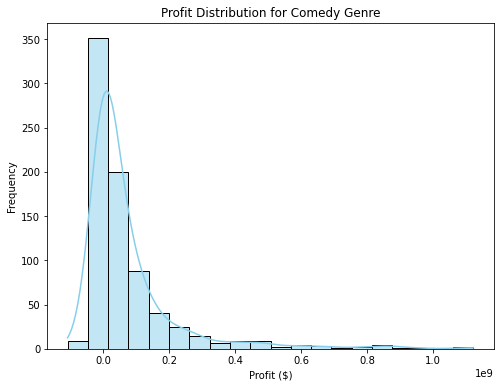

In [59]:
# Plotting - this visualizes the distribution of profit for comedy movies 

plt.figure(figsize=(8, 6))
sns.histplot(comedy_profit, color='skyblue', bins=20, kde=True)

# Adding labels and title
plt.xlabel('Profit ($)')
plt.ylabel('Frequency')
plt.title('Profit Distribution for Comedy Genre')

# Show plot
plt.show()

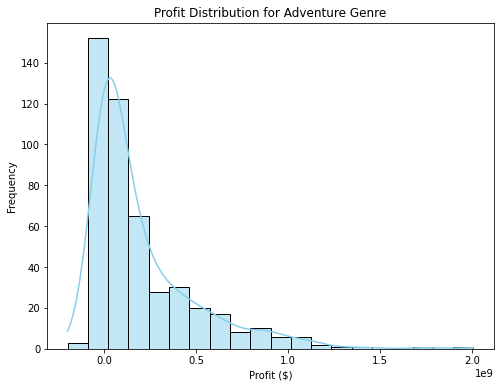

In [60]:
# Plotting - this visualizes the distribuation of profit for adventure movies 

plt.figure(figsize=(8, 6))
sns.histplot(adventure_profit, color='skyblue', bins=20, kde=True)

# Adding labels and title
plt.xlabel('Profit ($)')
plt.ylabel('Frequency')
plt.title('Profit Distribution for Adventure Genre')

# Show plot
plt.show()

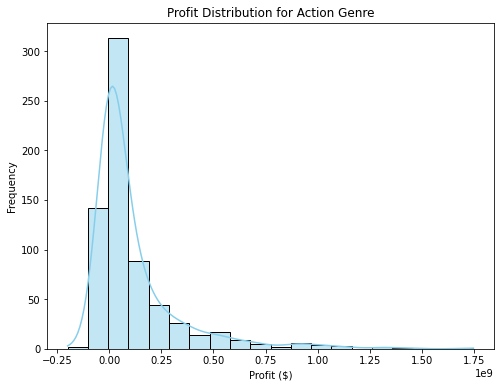

In [61]:
# Plotting - this visualizes the distribuation of profit for action movies 

plt.figure(figsize=(8, 6))
sns.histplot(action_profit, color='skyblue', bins=20, kde=True)

# Adding labels and title
plt.xlabel('Profit ($)')
plt.ylabel('Frequency')
plt.title('Profit Distribution for Action Genre')

# Show plot
plt.show()

In [62]:
comedy_mean_profit = comedy_profit.mean()
comedy_median_profit = comedy_profit.median()
print(comedy_mean_profit)
print(comedy_median_profit)

75222558.21141374
21078541.0


In [63]:
adventure_mean_profit = adventure_profit.mean()
adventure_median_profit = adventure_profit.median()
print(adventure_mean_profit)
print(adventure_median_profit)

201471744.25581396
73336398.0


In [64]:
action_mean_profit = action_profit.mean()
action_median_profit = action_profit.median()
print(action_mean_profit)
print(action_median_profit)

118845445.04270987
33306268.0


In [65]:
drama_mean_profit = drama_profit.mean()
drama_median_profit = drama_profit.median()
print(drama_mean_profit)
print(drama_median_profit)

37608022.178266175
4852084.0


In [66]:
horror_mean_profit = horror_profit.mean()
horror_median_profit = horror_profit.median()
print(horror_mean_profit)
print(horror_median_profit)

49026151.505494505
12067488.0


In [67]:
scifi_mean_profit = scifi_profit.mean()
scifi_median_profit = scifi_profit.median()
print(scifi_mean_profit)
print(scifi_median_profit)

172679590.96666667
29571147.5


In [68]:
musical_mean_profit = musical_profit.mean()
musical_median_profit = musical_profit.median()
print(musical_mean_profit)
print(musical_median_profit)

193801914.36363637
37700000.0


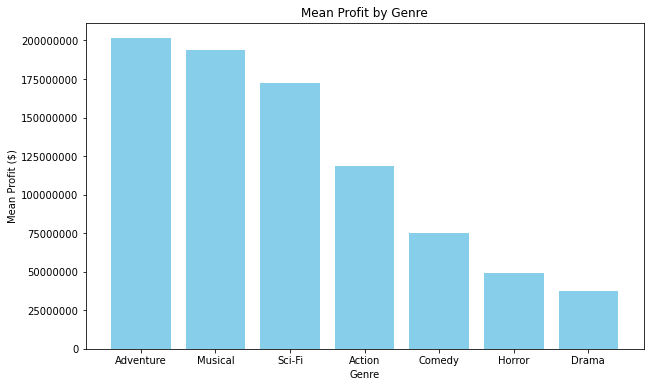

In [69]:
# Visual for mean profit v genre 
genres = ['Adventure', 'Musical', 'Sci-Fi', 'Action', 'Comedy', 'Horror', 'Drama']
means = [adventure_mean_profit, musical_mean_profit, scifi_mean_profit, action_mean_profit, 
        comedy_mean_profit, horror_mean_profit, drama_mean_profit]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(genres, means, color='skyblue')

# Adding labels and title
plt.xlabel('Genre')
plt.ylabel('Mean Profit ($)')
plt.title('Mean Profit by Genre')
plt.ticklabel_format(style = 'plain', axis='y')

# Show plot
plt.show()

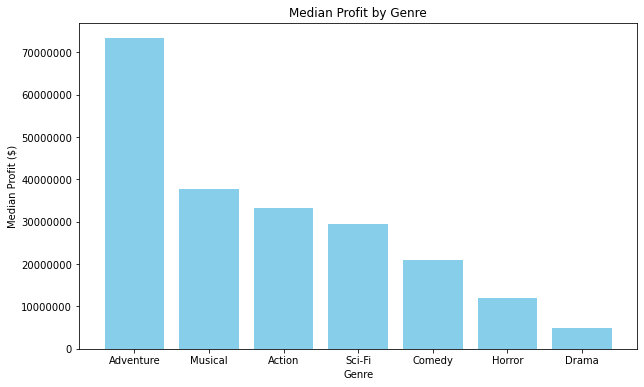

In [70]:
# Visual for median profit v genre 
genres = ['Adventure', 'Musical', 'Action', 'Sci-Fi', 'Comedy', 'Horror', 'Drama']
medians = [adventure_median_profit, musical_median_profit, action_median_profit, scifi_median_profit,
          comedy_median_profit, horror_median_profit, drama_median_profit]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(genres, medians, color='skyblue')

# Adding labels and title
plt.xlabel('Genre')
plt.ylabel('Median Profit ($)')
plt.title('Median Profit by Genre')
plt.ticklabel_format(style = 'plain', axis='y')

# Show plot
plt.show()

### *****Need to include the Business Recommendations sections and Takeaways, and Limitations

<hr style="border:1px solid gray">

## Analysis Part 3 - Exploring Relationship Between Production Budget and Profits

This section evaluates the relationship between production budget and profit using a linear regression model.

In [72]:
#Defining X variable as Production Budget
#Defining Y Variable as Profit

x_production_budget = movie_budget_df['production_budget']
y_profit = movie_budget_df['profit']

In [73]:
#Manually Build Out Linear Regression
rho = np.corrcoef(x_production_budget, y_profit)[0][1]
s_y = y_profit.std()
s_x = x_production_budget.std()

m = rho * s_y / s_x

mean_y = y_profit.mean()
mean_x = x_production_budget.mean()
c = mean_y - m * mean_x

print(f"Our regression line is: y = {round(m, 5)}x + {round(c, 5)}")

Our regression line is: y = 2.12694x + -7285667.05459


In [74]:
#The manual construction above provides the equation for the line of best fit.
#To look at other metrics, we utilize the StatsModel

x_production_budget_plus_c = sm.add_constant(x_production_budget)

In [75]:
model = sm.OLS(y_profit, x_production_budget_plus_c).fit()

In [76]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     3403.
Date:                Tue, 26 Mar 2024   Prob (F-statistic):               0.00
Time:                        14:43:04   Log-Likelihood:            -1.1557e+05
No. Observations:                5782   AIC:                         2.311e+05
Df Residuals:                    5780   BIC:                         2.311e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -7.286e+06   1.91e+06     -3.813      0.000    -1.1e+07   -3.54e+06
production_budget     2.1269      0.036     58.336      0.000       2.055       2.198
==============================================================================
Omnibus:                     4232.022   Durbin-Watson:                   1.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           172398.262
Skew:                           3.053   Prob(JB):                         0.00
Kurtosis:                      29.044   Cond. No.                     6.57e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.57e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Observations
- Our model is statistically significant, with a p-value well below the standard alpha of 0.05.
- Our model explains about 37.1% of the variance in profit, which is our dependent variable.
- For a production budget of 0, our model would predict a profit of \-$7,286,000. An increase of 1 in production budget is associated with an increase of \\$2.13 in profit.
    - **Check:** The StatsModel values are the same values that were calculated manually above.

In [77]:
#Creating custom number formatters for charting purposes
def MM_formatter(x, pos):
    return f'${x/1e6:.1f} MM'

def Bn_formatter(x,pos):
    return f'${x/1e9:.1f} Bn'

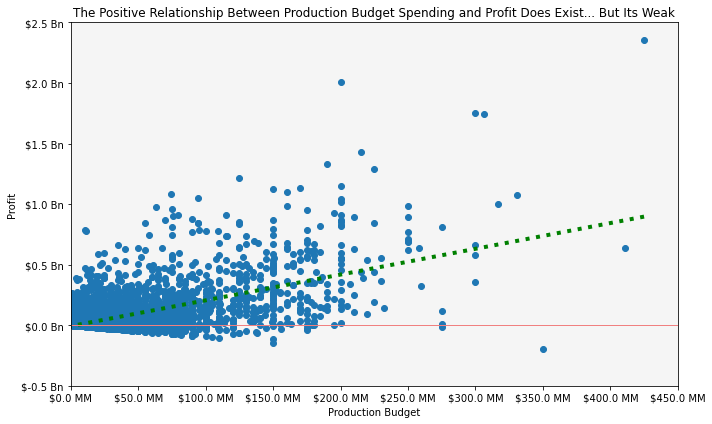

In [78]:
#Look at Scatter Plot
fig, ax = plt.subplots(figsize=(10,6))
ax.set_facecolor('whitesmoke')

ax.scatter(x_production_budget, y_profit)
ax.plot(x_production_budget, (m*x_production_budget+c), linewidth=4, color='g', linestyle=':')

#This line here is y=0. All the data points below this are unprofitable
ax.axhline(linewidth=1, color='lightcoral') 

#Create a ScalarFormatter object
formatter1 = ticker.FuncFormatter(MM_formatter)
formatter2 = ticker.FuncFormatter(Bn_formatter)

#Applying the formatter to both x and y axes
ax.yaxis.set_major_formatter(formatter2)
ax.xaxis.set_major_formatter(formatter1)

ax.set_xlabel('Production Budget')
ax.set_ylabel('Profit')
ax.set_title('The Positive Relationship Between Production Budget Spending and Profit Does Exist... But Its Weak')

plt.xlim(0,4.5e8)
plt.ylim(-.5e9,2.5e9)
plt.tight_layout()

### Conclusion
Based on the R^2 value, 37.1% of the variability in profit can be explained by the production budget. While the model explains a sizable portion of the variability, there is still a substantial amount of unexplained variation.

### Limitations to the Analysis
- We have assumed a linear relationship. However, given the current R^2, the model may not have captured the complexity of the data accurately. We could improve on our analysis by utilizing a multiple linear regression model.
- While we implemented a thorough data preparation process, there may be other data points that should have been removed to improve the effectiveness of our analysis.

##  Analysis Part 3a - Additional Analysis on a Specific Genre
To investigate whether the conclusion drawn from the third analysis may differ for a given genre, the team has conducted a linear regression model on the comedy movies.

To start, we create a new dataframe column to divide comedy from non-comedy movies

In [79]:
df_merged_mb['comedy_or_other'] = df_merged_mb['genres'].apply(lambda x: 'Comedy' if x is not None and 'Comedy' in x else 'Other')

In [80]:
#Checking if the above code went through

df_merged_mb['comedy_or_other'].value_counts()

Other     2594
Comedy     771
Name: comedy_or_other, dtype: int64

In [83]:
#Created two dataframes: One for comedy and one for other

df_comedy = df_merged_mb[df_merged_mb['comedy_or_other'] == 'Comedy']
df_other = df_merged_mb[df_merged_mb['comedy_or_other'] == 'Other']

In [85]:
#We look at the df_comedy dataframe as a check

df_comedy.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,comedy_or_other
11,15,"Nov 24, 2010",Tangled,260000000,200821936,586477240,326477240,tt0398286,Tangled,Tangled,2010,100.0,"Adventure,Animation,Comedy",Comedy
26,35,"May 25, 2012",Men in Black 3,215000000,179020854,654213485,439213485,tt1409024,Men in Black 3,Men in Black 3,2012,106.0,"Action,Adventure,Comedy",Comedy
46,46,"Jun 17, 2016",Finding Dory,200000000,486295561,1021215193,821215193,tt2277860,Finding Dory,Finding Dory,2016,97.0,"Adventure,Animation,Comedy",Comedy
47,47,"Jun 18, 2010",Toy Story 3,200000000,415004880,1068879522,868879522,tt0435761,Toy Story 3,Toy Story 3,2010,103.0,"Adventure,Animation,Comedy",Comedy
56,53,"Jun 21, 2013",Monsters University,200000000,268488329,743588329,543588329,tt1453405,Monsters University,Monsters University,2013,104.0,"Adventure,Animation,Comedy",Comedy


In [86]:
#Defining X variable as Production Budget
#Defining Y Variable as Profit

x_comedy_prod_budget = np.array(df_comedy['production_budget'])
y_comedy_profit = np.array(df_comedy['profit'])

In [87]:
#Manually Build Out Linear Regression
rho_comedy = np.corrcoef(x_comedy_prod_budget, y_comedy_profit)[0][1]
s_y_comedy = y_comedy_profit.std()
s_x_comedy = x_comedy_prod_budget.std()

m_comedy = rho_comedy * s_y_comedy / s_x_comedy

mean_y_comedy = y_comedy_profit.mean()
mean_x_comedy = x_comedy_prod_budget.mean()
c_comedy = mean_y_comedy - m_comedy * mean_x_comedy

print(f"Our regression line is: y = {round(m_comedy, 5)}x + {round(c_comedy, 5)}")

Our regression line is: y = 2.25141x + -5510338.31447


In [88]:
x_comedy_prod_budget_plus_c = sm.add_constant(x_comedy_prod_budget)

In [89]:
model_comedy = sm.OLS(y_comedy_profit, x_comedy_prod_budget_plus_c).fit()

In [90]:
model_comedy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     423.6
Date:                Tue, 26 Mar 2024   Prob (F-statistic):           2.53e-75
Time:                        14:49:07   Log-Likelihood:                -15443.
No. Observations:                 771   AIC:                         3.089e+04
Df Residuals:                     769   BIC:                         3.090e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -5.51e+06   5.87e+06     -0.939      0.348    -1.7e+07       6e+06
x1             2.2514      0.109     20.583      0.000       2.037       2.466
==============================================================================
Omnibus:                      504.863   Durbin-Watson:                   1.337
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8351.336
Skew:                           2.695   Prob(JB):                         0.00
Kurtosis:                      18.195   Cond. No.                     7.21e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.21e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Observations
- Our model is statistically significant, with a p-value well below the standard alpha of 0.05.
- Our model explains about 35.5% of the variance in profit, which is our dependent variable.
- For a production budget of 0, our model would predict a profit of \-$5,510,000. An increase of 1 in production budget is associated with an increase of \\$2.25 in profit.
    - **Check:** The StatsModel values are the same values that were calculated manually above.

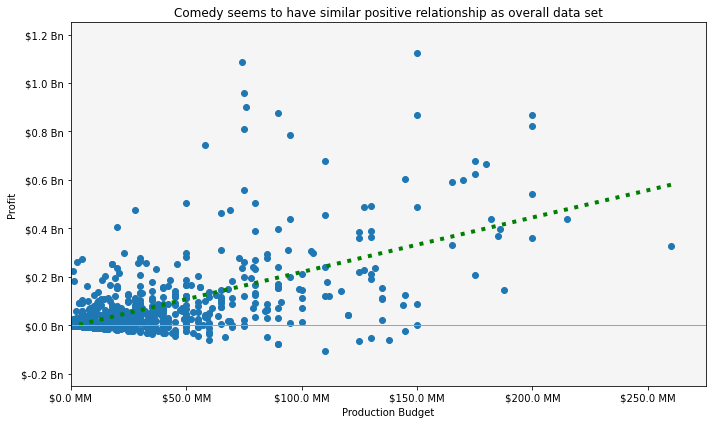

In [91]:
#Look at Scatter Plot and line of best fit for comedy movies
fig, ax = plt.subplots(figsize=(10,6))
ax.set_facecolor('whitesmoke')

ax.scatter(x_comedy_prod_budget, y_comedy_profit)
ax.plot(x_comedy_prod_budget, (m_comedy*x_comedy_prod_budget+c_comedy), linewidth=4, color='g', linestyle=':')

#This line hear is y=0. All the data points below this are unprofitable
ax.axhline(linewidth=1, color='lightcoral') 

#Create a ScalarFormatter object
formatter1 = ticker.FuncFormatter(MM_formatter)
formatter2 = ticker.FuncFormatter(Bn_formatter)

#Applying the formatter to both x and y axes
ax.yaxis.set_major_formatter(formatter2)
ax.xaxis.set_major_formatter(formatter1)

ax.set_xlabel('Production Budget')
ax.set_ylabel('Profit')
ax.set_title('Comedy seems to have similar positive relationship as overall data set')

plt.xlim(0,2.75e8)
plt.ylim(-.25e9,1.25e9)
plt.tight_layout()

### Conclusion
Based on the R^2 value, 35.5% of the variability in profit can be explained by the production budget for comedy movies. While the model explains a sizable portion of the variability, there is still a substantial amount of unexplained variation.

### Third Recommendation

Based on the analyses, **S-Trio Entertainment** should be cognizant of the fact that production budget has a sizable impact on the profitability of the movie but it is not the sole determining factor. When planning for production budgets, our team recommends spending strategically to avoid unnecessary losses.

Based on our linear recommendation model across all movie categories:
- For every dollar spent on the production budget, \\$2.13 in profits is typically generated
- At least \\$3.4 million in production budget is need to breakeven
- To clear \\$1 million in profits, we recommend a production budget of \\$3.9 million.

<hr style="border:2px solid gray">

# Conclusion